In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

In [2]:
data_filenames = [
   "attacking_examples.csv",
   "completing_quest_examples.csv",
   "delivering_examples.csv",
   "drival_examples.csv",
   "exchanging_examples.csv",
   "farewell_examples.csv",
   "following_examples.csv",
   "general_examples.csv",
   "greeting_examples.csv",
   "joining_examples.csv",
   "joke_examples.csv",
   "knowledge_examples.csv",
   "moving_examples.csv",
   "protecting_examples.csv",
   "recieving_quest_examples.csv",
   "saying_examples.csv",
   "threatening_examples.csv"
]
len(data_filenames)

17

In [3]:
data_dfs = []
train_data_dfs = []
valid_data_dfs = []
test_data_dfs = []
for filename in tqdm(data_filenames):
   current_df = pd.read_csv(filename, sep=";", index_col=False)
   current_train_df = current_df.iloc[:int(0.8*len(current_df)),:].reset_index(drop=True)
   current_valid_df = current_df.iloc[int(0.8*len(current_df)):int(0.9*len(current_df)),:].reset_index(drop=True)
   current_test_df = current_df.iloc[int(0.9*len(current_df)):,:].reset_index(drop=True)
   data_dfs.append(current_df)
   train_data_dfs.append(current_train_df)
   valid_data_dfs.append(current_valid_df)
   test_data_dfs.append(current_test_df)
data_df = pd.concat(data_dfs, ignore_index=True).reset_index(drop=True)
train_data_df = pd.concat(train_data_dfs, ignore_index=True).reset_index(drop=True)
valid_data_df = pd.concat(valid_data_dfs, ignore_index=True).reset_index(drop=True)
test_data_df = pd.concat(test_data_dfs, ignore_index=True).reset_index(drop=True)

100%|██████████| 17/17 [00:00<00:00, 153.86it/s]


In [4]:
data_df = data_df.sample(frac=1).reset_index(drop=True)
train_data_df = train_data_df.sample(frac=1).reset_index(drop=True)
valid_data_df = valid_data_df.sample(frac=1).reset_index(drop=True)
test_data_df = test_data_df.sample(frac=1).reset_index(drop=True)

In [5]:
for i in tqdm(range(len(data_df["label_names"]))):
   if data_df["label_names"][i] == "Complete quest":
      data_df["label_names"][i] = "Complete"
   if data_df["label_names"][i] == "Recieve quest":
      data_df["label_names"][i] = "Recieve"

100%|██████████| 163221/163221 [00:03<00:00, 42308.63it/s]


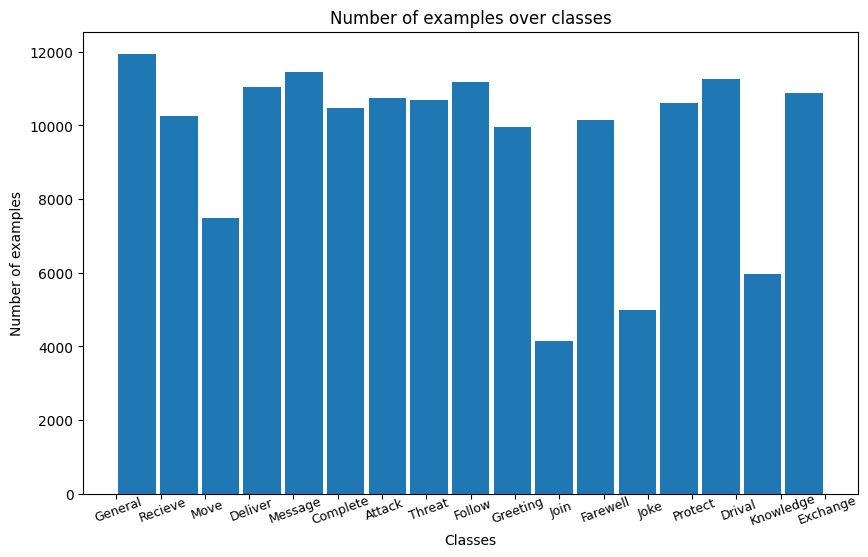

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(data_df["label_names"], bins=17, align='mid', rwidth=0.9, )
plt.title("Number of examples over classes")
plt.xlabel("Classes")
plt.xticks(fontsize=9, rotation=20, rotation_mode="anchor")
plt.ylabel("Number of examples")
plt.show()

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

In [7]:
lengths = []
for example in tqdm(data_df["examples"]):
   tokenized_input = tokenizer.tokenize(example)
   lengths.append(len(tokenized_input))

100%|██████████| 163221/163221 [00:04<00:00, 39277.91it/s]


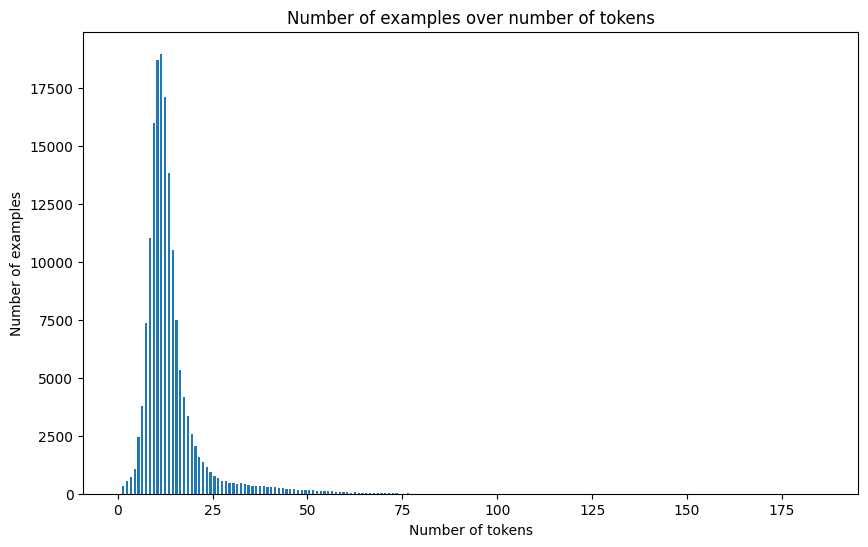

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(lengths,bins=range(max(lengths)+2), align='mid', rwidth=0.6)
plt.title("Number of examples over number of tokens")
plt.xlabel("Number of tokens")
plt.ylabel("Number of examples")
plt.show()

In [7]:
label2id = {
    "Attack":0,
    "Complete quest": 1,
    "Deliver":2,
    "Drival":3,
    "Exchange": 4,
    "Farewell": 5,
    "Follow": 6,
    "General": 7,
    "Greeting": 8,
    "Join": 9,
    "Joke": 10,
    "Knowledge":11,
    "Move":12,
    "Protect": 13,
    "Recieve quest": 14,
    "Message": 15,
    "Threat": 16
}

In [8]:
def add_labels(data, label2id):
   ids = []
   for label_name in tqdm(data["label_names"]):
      ids.append(label2id[label_name])
   data["labels"] = ids

   return data

In [9]:
train_data_df = add_labels(train_data_df, label2id)
valid_data_df = add_labels(valid_data_df, label2id)
test_data_df = add_labels(test_data_df, label2id)

100%|██████████| 16330/16330 [00:00<00:00, 6777457.38it/s]


In [18]:
train_data_df.to_parquet("train_data.parquet", row_group_size=100, engine="pyarrow", index=False)
valid_data_df.to_parquet("valid_data.parquet", row_group_size=100, engine="pyarrow", index=False)
test_data_df.to_parquet("test_data.parquet", row_group_size=100, engine="pyarrow", index=False)

In [10]:
train_dataset = Dataset.from_parquet("train_data.parquet")
valid_dataset = Dataset.from_parquet("valid_data.parquet")
test_dataset = Dataset.from_parquet("test_data.parquet")

Found cached dataset parquet (/home/michael/.cache/huggingface/datasets/parquet/default-7b55b5ccb6e29e44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/michael/.cache/huggingface/datasets/parquet/default-bbc9c1b6c047f1d5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/michael/.cache/huggingface/datasets/parquet/default-6e4fd99312da6ac3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [21]:
dataset = DatasetDict({
   "train":train_dataset,
   "test":test_dataset,
   "eval":valid_dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['examples', 'label_names', 'labels'],
        num_rows: 130570
    })
    test: Dataset({
        features: ['examples', 'label_names', 'labels'],
        num_rows: 16330
    })
    eval: Dataset({
        features: ['examples', 'label_names', 'labels'],
        num_rows: 16321
    })
})